In [1]:
# This Notebook developed based on the starter notebook of https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
#try:
import tensorflow as tf
#from keras import layers, optimizers
from tensorflow.keras import layers, optimizers
'''except ImportError:
    !pip install numpy==1.24.4 tensorflow==2.15.0 tensorflow-addons==0.21.0 keras==2.15.0 keras-cv keras-nlp
    !pip install shapely==2.0.1 packaging==23.1 pyarrow==9.0.0 cuda-python==11.8.0 typeguard==4.1.3
    !pip install dill==0.3.1.1
    !pip install cubinlinker cupy-cuda11x==12.0.0 ptxcompiler wurlitzer libucx<1.16,>=1.15.0


    # Install necessary packages if they are missing
    !pip uninstall numpy shapely packaging pyarrow cuda-python typeguard --yes
    !rm -rf /opt/conda/lib/python3.10/site-packages/numpy-1.26.4.dist-info
    !pip install numpy<1.26
    !pip install tensorflow==2.15.0 tensorflow-addons==0.21.0 keras==2.15.0 keras-cv keras-nlp
    !pip install numpy<1.25
    !pip install shapely>=2.0
    !pip install packaging>=23.1
    !pip install pyarrow<10.0
    !pip install cuda-python<12.0a0,>=11.7.1
    !pip install typeguard<5
    import tensorflow as tf
    from tensorflow.keras import layers, optimizers
    import tensorflow_addons as tfa'''

import matplotlib.pyplot as plt
import numpy as np

# TPU Setup
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except Exception as e:
    print("TPU setup failed:", e)
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)
AUTOTUNE = tf.data.AUTOTUNE
    
print(tf.__version__)


E0000 00:00:1725594632.435149      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D0906 03:50:32.443542925      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0906 03:50:32.443558339      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0906 03:50:32.443561650      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0906 03:50:32.443564260      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0906 03:50:32.443566606      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1725594645.526508      13 service.cc:145] XLA service 0x5a52dbdfff00 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725594645.526557      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1725594645.526562      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1725594645.526565      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1725594645.526568      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1725594645.526570      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1725594645.526573      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1725594645.526576      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1725594645.526578      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

## Load in the data 
We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.  Make sure You added the competition dataset as input of the notebook if you run it on Kaggle.

![right panel of Kaggle](Repo_images/Dataset_Loading.png)

In [2]:
gcs_path = "/kaggle/input/gan-getting-started"

print(gcs_path)
MONET_FILENAMES = tf.io.gfile.glob(str(gcs_path + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(gcs_path + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

/kaggle/input/gan-getting-started
Monet TFRecord Files: 5
Photo TFRecord Files: 20


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [3]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Define the function to extract the image from the files.

In [4]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [5]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [6]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Let's visualize a photo example and a Monet example.

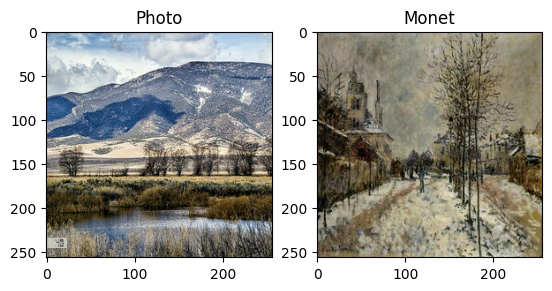

In [7]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)


## Build the generator

We'll be using a UNET architecture for our CycleGAN. To build our generator, let's first define our downsample and upsample methods.

The downsample, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using an instance normalization instead of batch normalization. As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons.


In [8]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

Upsample does the opposite of downsample and increases the dimensions of the of the image. Conv2DTranspose does basically the opposite of a Conv2D layer.

In [9]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Let's build our generator!

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.


In [10]:
import tensorflow as tf
from tensorflow.keras import layers
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.


In [11]:
import tensorflow as tf
from tensorflow.keras import layers

class InstanceNormalization(layers.Layer):
    def __init__(self, gamma_initializer=None, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.gamma_initializer = gamma_initializer
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=(input_shape[-1],),
                                     initializer=self.gamma_initializer,
                                     trainable=True,
                                     name='gamma')
        self.beta = self.add_weight(shape=(input_shape[-1],),
                                    initializer='zeros',
                                    trainable=True,
                                    name='beta')

    def call(self, inputs, training=False):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

# Example usage in a custom model
def example_model():
    inputs = tf.keras.Input(shape=[256, 256, 3])
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = InstanceNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    # Add more layers as needed
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model


In [12]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [13]:
#import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras import layers

def downsample(filters, size, apply_instancenorm=True):
    # Use tf.keras.initializers.RandomNormal
    initializer = tf.keras.initializers.RandomNormal(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(layers.LayerNormalization(gamma_initializer=gamma_init, epsilon=1e-5))
    result.add(layers.LeakyReLU())
    
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.keras.initializers.RandomNormal(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    
    return result

with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

I0000 00:00:1725594718.968972      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

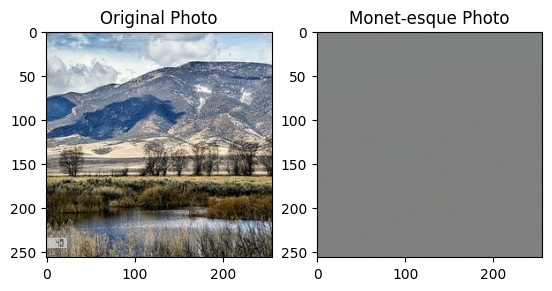

In [14]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()


## Build the CycleGAN model

We will subclass a tf.keras.Model so that we can run fit() later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [15]:
class CycleGan(tf.keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }



## Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.


In [16]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [17]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [18]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [19]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss


## Train the CycleGAN

Let's compile our model. Since we used tf.keras.Model to build our CycleGAN, we can just ude the fit function to train our model.


In [20]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [21]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [22]:
import tensorflow as tf

class CycleGan(tf.keras.Model):
    def __init__(self, generator_g, generator_f, discriminator_x, discriminator_y):
        super(CycleGan, self).__init__()
        self.generator_g = generator_g
        self.generator_f = generator_f
        self.discriminator_x = discriminator_x
        self.discriminator_y = discriminator_y

    def call(self, inputs, training=False):
        # Assuming inputs is a tuple (real_x, real_y)
        real_x, real_y = inputs
        
        # Forward pass through generators
        fake_y = self.generator_g(real_x, training=training)
        cycled_x = self.generator_f(fake_y, training=training)
        
        fake_x = self.generator_f(real_y, training=training)
        cycled_y = self.generator_g(fake_x, training=training)
        
        # Forward pass through discriminators
        disc_real_x = self.discriminator_x(real_x, training=training)
        disc_fake_x = self.discriminator_x(fake_x, training=training)
        
        disc_real_y = self.discriminator_y(real_y, training=training)
        disc_fake_y = self.discriminator_y(fake_y, training=training)
        
        return (fake_y, cycled_x, disc_real_x, disc_fake_x, fake_x, cycled_y, disc_real_y, disc_fake_y)


In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=20
)

Epoch 1/20


## Visualize our Monet-esque photos

NameError: name 'photo_ds' is not defined

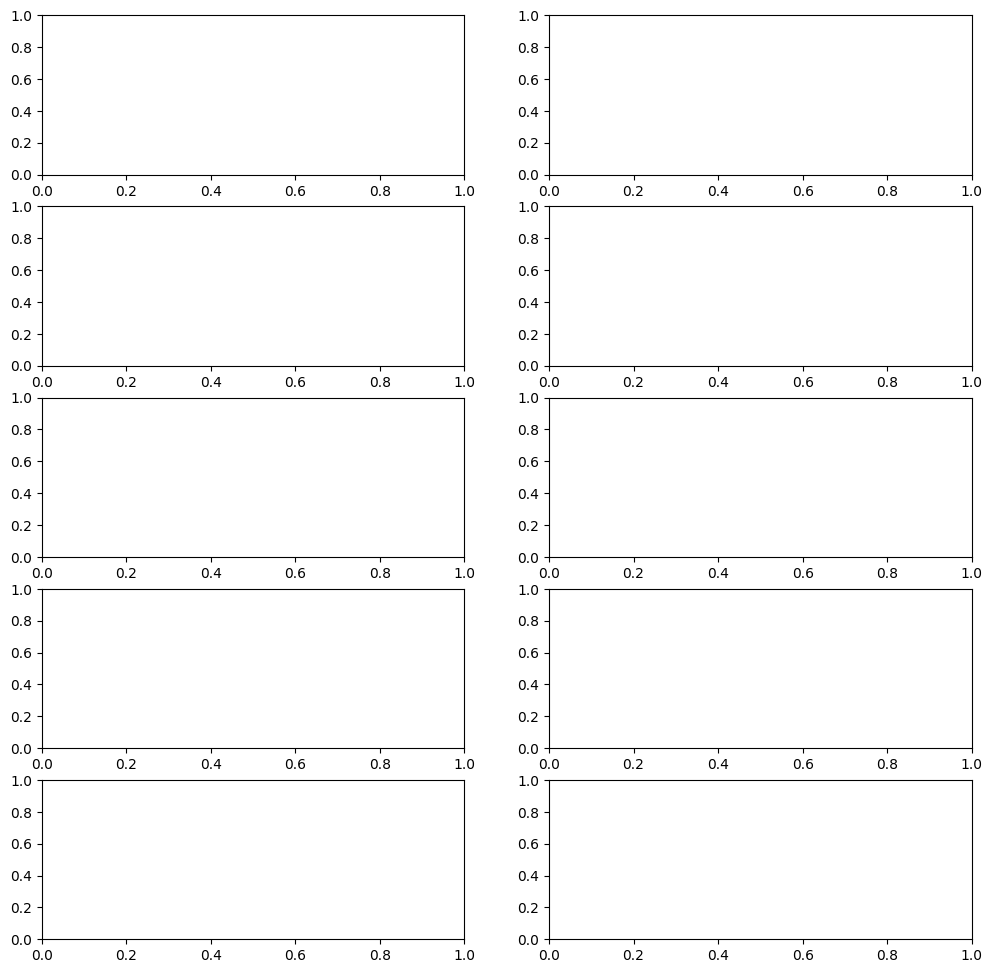

In [2]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()